# LiH - Confronti tra metodi UCC ~ 22 min

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Array distanze e energie
arr_distance = np.arange(0.75, 4., 0.25) # 13 punti 
arr_ground_energy = {}
arr_intermediate  = {}
arr_results = {}
arr_methods = []
times = {}

## 0 - LiH

In [3]:
from pyscf import gto, scf, fci
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers  import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

In [4]:
def generate_LiH_mol (distance: float = 0.1, basis: str = 'sto3g'):
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=LiH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=False,
        verbose=0
    )
    
    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
    )    
    
    problem = driver.run()
    
    return mol, problem
    
    

### 0.1 - HF e FCI

In [5]:
arr_ground_energy['HF'] = []

arr_ground_energy['FCI'] = []
arr_results['FCI'] = []
arr_methods.append('FCI')

def compute_fci_energy (mol):
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    n_frozen_orbitals = 1
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]

    return e_HF, e_FCI

### 0.2 - EfficientSU2

In [6]:
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.mappers import QubitMapper, JordanWignerMapper, ParityMapper

arr_ground_energy['EfficientSU2'] = []
arr_intermediate ['EfficientSU2'] = []
arr_results['EfficientSU2'] = []
arr_methods.append('EfficientSU2')
ini_efficient = None
times['EfficientSU2'] = None

def generate_efficient_ansatz (problem: ElectronicStructureProblem, mapper: JordanWignerMapper()):
    # numero di qubits dell'operatore
    second_q_op = problem.second_q_ops()[0]
    qubit_op = mapper.map(second_q_op)
    num_qubits = qubit_op.num_qubits
    
    efficient = EfficientSU2(num_qubits, entanglement='reverse_linear') 
    
    ini_efficient = [0. for _ in range(efficient.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(efficient.num_parameters)]
    efficient._bounds = bounds
    
    return efficient

## 1- UCC Methods

In [7]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC, UCCSD, PUCCD

### 1.1 - UCCS

In [8]:
arr_ground_energy['UCCS'] = []
arr_intermediate ['UCCS'] = []
arr_results['UCCS'] = []
arr_methods.append('UCCS')
ini_uccs = None
times['UCCS'] = None

def generate_uccs_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccs = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='s',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccs = [0. for _ in range(uccs.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccs.num_parameters)]
    uccs._bounds = bounds
    
    return uccs

### 1.2 - UCCD 

In [9]:
arr_ground_energy['UCCD'] = []
arr_intermediate ['UCCD'] = []
arr_results['UCCD'] = []
arr_methods.append('UCCD')
ini_uccd = None
times['UCCD'] = None

def generate_uccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccd = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='d',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccd = [0. for _ in range(uccd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccd.num_parameters)]
    uccd._bounds = bounds
    
    return uccd

### 1.3 - UCCSD

In [10]:
arr_ground_energy['UCCSD'] = []
arr_intermediate ['UCCSD'] = []
arr_results['UCCSD'] = []
arr_methods.append('UCCSD')
ini_uccsd = None
times['UCCSD'] = None

def generate_uccsd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccsd = UCCSD(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        #excitations='sd',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccsd = [0. for _ in range(uccsd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(uccsd.num_parameters)]
    uccsd._bounds = bounds
    
    return uccsd

### 1.4 - pUCCD

In [11]:
arr_ground_energy['pUCCD'] = []
arr_intermediate ['pUCCD'] = []
arr_results['pUCCD'] = []
arr_methods.append('pUCCD')
ini_puccd = None
times['pUCCD'] = None

def generate_puccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    
    puccd = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_puccd = [0. for _ in range(puccd.num_parameters)]
    bounds = [[-np.pi,np.pi] for _ in range(puccd.num_parameters)]
    puccd._bounds = bounds
    
    return puccd

### Aiuti

In [12]:
ini_uccd = [0.02265631, -0.007787484, 3.139672, 3.097497, -0.001903558,
 0.03151177, -0.00186963, 3.136378, -3.143199, 3.142751,
 3.179203, 3.140637, 0.04329709, -3.144375, 3.143464,
 -0.09673738]

In [13]:
ini_uccsd = [-0.01877147, -0.04941062, -0.1251208, 1.528925, -1.504983,
            3.815334, 3.23566, 1.742724, -2.810608, 2.581604,
            2.654631, 2.963959, -1.659677, -1.703403, -1.839795,
            -2.28938, 1.467188, 3.148665, -0.3665278, 0.05325239,
            4.551188, -0.04134156, 3.146543, -0.1515372]

## 2 - Solver

In [14]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, NFT, L_BFGS_B
from qiskit.primitives import Estimator 
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [15]:
# vettori che andranno a raccogliere i risultati delle varie iterazioni dell'algoritmo
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [16]:
def solve_problem (problem: ElectronicStructureProblem, 
                   ansatz: UCC, 
                   intermediate: list = None,
                   ini: np.ndarray = None, 
                   opt=SLSQP(maxiter=1000), 
                   mapper: QubitMapper = JordanWignerMapper()):
    
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    # conservo i valori intermedi
    if intermediate is not None:
        intermediate = [counts,values]
    
    
    return res

## 3 - Ex

In [17]:
# Parametri per la risoluzione
# SLSQP(maxiter=10) 22 min ma uccd ancora sballato in d<2.25
# SLSQP() 60 min ma uccsd ancora sballato
opt    = COBYLA(maxiter=5000, tol=0.01, rhobeg=3, disp=True) # 
mapper = JordanWignerMapper()
basis  = 'sto3g'

# Per conservare i tempi di esecuzione
from time import time

In [18]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
freezer = FreezeCoreTransformer()

In [ ]:
for distance in arr_distance:
    print('------------------------', distance, '------------------------')
    mol, problem = generate_LiH_mol(distance=distance, basis=basis)
    
    problem = freezer.transform(problem)
    
    # 0 - HF & FCI
    e_HF, e_FCI = compute_fci_energy(mol=mol)
    arr_ground_energy['HF'].append(e_HF)
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('HF:  ', e_HF)
    print('FCI: ', e_FCI)
    
    # 0.1 - EfficientSU2
    start_time = time()
    efficient = generate_efficient_ansatz(problem=problem,
                                          mapper=mapper
                                         )
    efficient_res = solve_problem(problem=problem,
                                  ansatz=efficient, 
                                  intermediate=arr_intermediate['EfficientSU2'],
                                  ini=ini_efficient,
                                  opt=opt,
                                  mapper=mapper
                                 )
    
    # conservo il result
    arr_results['EfficientSU2'].append(efficient_res)
    # conservo l'energia
    shift = efficient_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_efficient = efficient_res.groundenergy + efficient_res.nuclear_repulsion_energy + shift
    arr_ground_energy['EfficientSU2'].append(e_efficient)
    # conservo l'optimal point
    ini_efficient = efficient_res.raw_result.optimal_point
    
    efficient_time = time() - start_time
    print('EfficientSU2: ', e_efficient, ' | time: ', efficient_time)
    
    # 1 - UCCS 
    start_time = time()
    uccs  = generate_uccs_ansatz (problem=problem, mapper=mapper)
    uccs_res = solve_problem(problem=problem,
                             ansatz=uccs, 
                             intermediate=arr_intermediate['UCCS'],
                             ini=ini_uccs,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCS'].append(uccs_res)
    # conservo l'energia
    shift = uccs_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccs = uccs_res.groundenergy + uccs_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCS'].append(e_uccs)
    # conservo l'optimal point
    ini_uccs = uccs_res.raw_result.optimal_point
    
    uccs_time = time() - start_time
    print('UCCS: ', e_uccs, ' | time: ', uccs_time)
    
    # 2 - UCCD
    start_time = time()
    uccd  = generate_uccd_ansatz (problem=problem, mapper=mapper)
    uccd_res = solve_problem(problem=problem,
                             ansatz=uccd, 
                             intermediate=arr_intermediate['UCCD'],
                             ini=ini_uccd,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCD'].append(uccd_res)
    # conservo l'energia
    shift = uccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccd = uccd_res.groundenergy + uccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCD'].append(e_uccd)
    # conservo l'optimal point
    ini_uccd = uccd_res.raw_result.optimal_point
    
    uccd_time = time() - start_time
    print('UCCD: ', e_uccd, ' | time: ', uccd_time)
    
    # 3 - UCCSD  
    start_time = time()
    uccsd = generate_uccsd_ansatz(problem=problem, mapper=mapper)
    uccsd_res = solve_problem(problem=problem,
                              ansatz=uccsd, 
                              intermediate=arr_intermediate['UCCSD'],
                              ini=ini_uccsd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['UCCSD'].append(uccsd_res)
    # conservo l'energia
    shift = uccsd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccsd = uccsd_res.groundenergy + uccsd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCSD'].append(e_uccsd)
    # conservo l'optimal point
    ini_uccsd = uccsd_res.raw_result.optimal_point
    
    uccsd_time = time() - start_time
    print('UCCSD: ', e_uccsd, ' | time: ', uccsd_time)
  
    
    # 4 - pUCCD
    start_time = time()
    puccd = generate_puccd_ansatz(problem=problem, mapper=mapper)
    puccd_res = solve_problem(problem=problem,
                              ansatz=puccd, 
                              intermediate=arr_intermediate['pUCCD'],
                              ini=ini_puccd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['pUCCD'].append(puccd_res)
    # conservo l'energia
    shift = puccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_puccd = puccd_res.groundenergy + puccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(e_puccd)
    # conservo l'optimal point
    ini_puccd = puccd_res.raw_result.optimal_point
    
    puccd_time = time() - start_time
    print('pUCCD: ', e_puccd, ' | time: ', puccd_time)

## 4 - Post-process & plotting

### 4.1 - Qubits, parameters

In [20]:
# Num qubits
print('Num Qubits:\n')
print('- efficient: ', efficient.num_qubits)
print('- uccs: ', uccs.num_qubits)
print('- uccd: ', uccd.num_qubits)
print('- uccsd: ', uccsd.num_qubits)
print('- puccd: ', puccd.num_qubits)
# Num parameters
print('Num Parameters:\n')
print('- efficient: ', efficient.num_parameters)
print('- uccs: ', uccs.num_parameters)
print('- uccd: ', uccd.num_parameters)
print('- uccsd: ', uccsd.num_parameters)
print('- puccd: ', puccd.num_parameters)

Num Qubits:

- efficient:  10
- uccs:  10
- uccd:  10
- uccsd:  10
- puccd:  10
Num Parameters:

- efficient:  80
- uccs:  8
- uccd:  16
- uccsd:  24
- puccd:  4


### 4.2 - Circuit comparisons

In [21]:
uccs  = uccs.decompose().decompose()
uccd  = uccd.decompose().decompose()
uccsd = uccsd.decompose().decompose()
puccd = puccd.decompose().decompose()

# Num gates
print('Num Gates:\n')
print('- efficient: ', efficient.count_ops())
print('- uccs: ', uccs.count_ops())
print('- uccd: ', uccd.count_ops())
print('- uccsd: ', uccsd.count_ops())
print('- puccd: ', puccd.count_ops())

# Depth
print('Depth:\n')
print('- efficient: ', efficient.depth())
print('- uccs: ', uccs.depth())
print('- uccd: ', uccd.depth())
print('- uccsd: ', uccsd.depth())
print('- puccd: ', puccd.depth())



Num Gates:

- efficient:  OrderedDict({'EfficientSU2': 1})
- uccs:  OrderedDict({'cx': 80, 'h': 64, 'sdg': 16, 'rz': 16, 's': 16, 'u3': 2})
- uccd:  OrderedDict({'cx': 1536, 'h': 1024, 'sdg': 256, 's': 256, 'rz': 128, 'u3': 2})
- uccsd:  OrderedDict({'cx': 1616, 'h': 1088, 'sdg': 272, 's': 272, 'rz': 144, 'u3': 2})
- puccd:  OrderedDict({'cx': 384, 'h': 256, 'sdg': 64, 's': 64, 'rz': 32, 'u3': 2})
Depth:

- efficient:  1
- uccs:  71
- uccd:  2032
- uccsd:  2098
- puccd:  511


### 4.2 - Plot

In [22]:
# includere Hartree-Fock
arr_methods.insert(0, 'HF')

In [23]:
# stile linea
arr_style = [
    ("orange", "o"),     # Cerchio giallo
    ("red", "s"),    # Quadrato arancio
    ("lime", "D"),      # Rombo verde chiaro
    ("green", "^"),   # Triangolo verde 
    ("orange", "v"),   # Triangolo capovolto arancione
    ("cyan", "P"),     # Pentagono ciano
    ("blue", "x")      # Croce blu
]

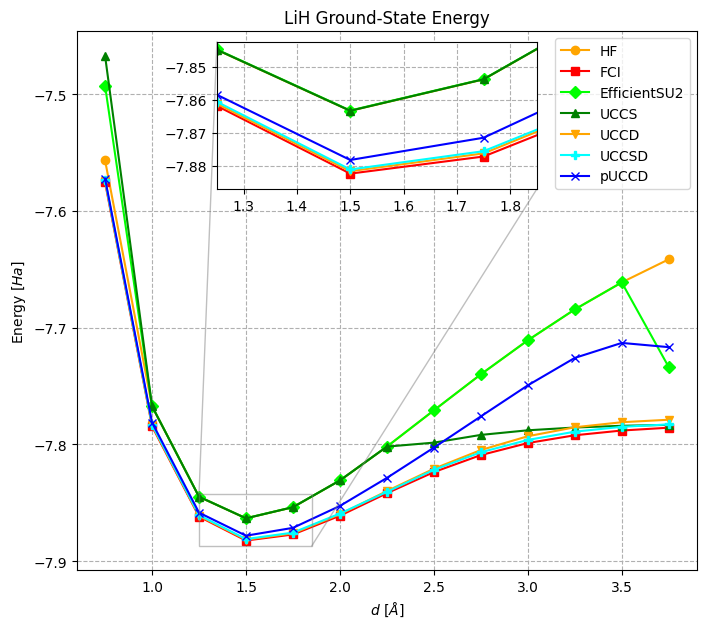

In [36]:
# Zoom sul minimo 1.25<x<1.8 e -7.9<y<-7.85
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met, style in zip(arr_methods,arr_style):  
    plt.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.30, .655, .4, .21]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.25,xmax=1.85)
ax_inset.axis(ymin=-7.887,ymax=-7.8425)

for met, style in zip(arr_methods,arr_style):  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()

# Messaggi status ottimizzazione 

In [ ]:
'''
------------------------ 0.75 ------------------------
HF:   -7.556721660246787
FCI:  -7.575486719856043
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_29233/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 5000   F =-1.050170E+00    MAXCV = 0.000000E+00
   X = 6.293099E+00   6.266212E+00   3.144484E+00  -2.121813E-02  -3.140911E+00
       1.591930E+00  -1.578354E+00   3.143647E+00   4.904062E+00  -2.675502E+00
       4.083199E+00   7.023723E-01   3.328701E-01   1.027379E+00   1.097430E+00
       1.500562E+00   1.221272E+00  -1.523424E+00   9.111765E-01  -3.302902E+00
       3.136480E+00  -2.835828E-03  -7.471901E-01   1.576391E+00   4.736129E+00
      -3.590087E-01   4.715770E+00  -4.582856E-02   3.728958E+00  -3.490190E+00
       5.270869E+00   5.577737E+00   6.291156E+00   3.139589E+00  -3.119967E+00
      -8.561018E-02  -3.252810E-01   2.788704E+00  -8.073443E-01  -3.025531E-02
       1.419049E-02  -1.196423E-02   3.890809E+00  -1.569782E+00  -1.581224E+00
       3.759021E+00   4.208046E+00   2.848993E+00  -3.143427E+00   2.098123E+00
      -3.268709E+00   1.287040E+00  -2.509673E+00  -2.962013E-01   2.450985E+00
      -3.135446E+00   1.561003E+00   1.581995E+00  -3.139396E+00  -3.470111E+00
       2.240421E-01  -2.349104E-03  -3.179265E+00  -3.144378E-02   3.004433E-02
      -9.548816E-01   1.704931E+00   1.565524E+00  -1.574999E+00   1.569758E+00
      -8.041440E-01   5.098784E-01   3.904975E+00  -1.025341E+00  -1.549926E-01
      -3.338448E+00   2.156665E+00  -4.548740E-01  -3.015540E+00   4.787131E-01
EfficientSU2:  -7.492903915099382  | time:  52.0533971786499
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_29233/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)

   Normal return from subroutine COBYLA

   NFVALS =   89   F =-1.024459E+00    MAXCV = 0.000000E+00
   X =-8.741988E-02   3.135397E+00   3.142419E+00   2.946585E+00  -1.609222E+00
       3.335994E+00   2.620448E+00  -2.108760E+00
UCCS:  -7.467193284206364  | time:  2.865356922149658
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_29233/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)

   Normal return from subroutine COBYLA

   NFVALS =   95   F =-1.131409E+00    MAXCV = 0.000000E+00
   X = 1.164117E-02  -2.049480E-03   3.143528E+00   3.112912E+00  -9.665212E-04
       5.049094E-02  -2.921021E-03   3.143176E+00  -3.140065E+00   3.143498E+00
       3.192248E+00   3.143661E+00   3.395601E-02  -3.147051E+00   3.139603E+00
      -9.601496E-02
UCCD:  -7.574143496424831  | time:  17.687419176101685

   Normal return from subroutine COBYLA

   NFVALS =  160   F =-1.130865E+00    MAXCV = 0.000000E+00
   X =-2.253016E-02  -5.023069E-02  -1.251509E-01   1.527661E+00  -1.503495E+00
       3.808691E+00   3.227480E+00   1.739104E+00  -2.729823E+00   2.649123E+00
       2.670859E+00   2.425720E+00  -1.650677E+00  -1.707850E+00  -2.315640E+00
      -2.263398E+00   1.472060E+00   3.151265E+00  -3.629124E-01   5.803059E-02
       4.555962E+00  -4.024952E-02   3.146140E+00  -1.529256E-01
UCCSD:  -7.57359941284335  | time:  32.476491928100586

   Normal return from subroutine COBYLA

   NFVALS =   60   F =-1.129495E+00    MAXCV = 0.000000E+00
   X =-3.324975E-03   3.192653E+00   6.337359E+00  -3.250088E+00
pUCCD:  -7.572229653093904  | time:  3.235114097595215
------------------------ 1.0 ------------------------
HF:   -7.767362135748553
FCI:  -7.784460280031227
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_29233/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)

   Normal return from subroutine COBYLA

   NFVALS = 1130   F =-1.157410E+00    MAXCV = 0.000000E+00
   X = 6.287704E+00   6.286966E+00   3.143778E+00  -1.710198E-02  -3.138518E+00
       1.584379E+00  -1.573696E+00   3.141598E+00   4.875876E+00  -2.709945E+00
       2.557921E+00   8.065071E-01   2.673670E-01   9.272969E-01  -3.697722E-01
       1.506076E+00   1.225153E+00   2.870912E+00   9.076922E-01  -3.329562E+00
       3.153832E+00  -1.200594E-03  -7.555327E-01   1.566857E+00   4.731064E+00
      -5.129390E-01   4.714243E+00  -4.857412E-02   3.717558E+00  -3.490519E+00
       5.824182E+00   6.008039E+00   6.285740E+00   3.142766E+00  -3.145703E+00
      -5.574420E-02  -4.649153E-01   2.791823E+00  -8.131998E-01  -3.631285E-02
       6.996841E-03   3.944573E-03   3.893825E+00  -1.563101E+00  -1.586724E+00
       3.716954E+00   4.074253E+00   3.026307E+00  -3.143180E+00   2.048491E+00
      -3.462608E+00   1.199072E+00  -2.203693E+00   3.484868E-02   2.697599E+00
      -3.135820E+00   1.548540E+00   1.565923E+00  -3.142618E+00  -3.468288E+00
       4.116417E-03  -5.489393E-02  -3.165493E+00  -1.797784E-02   3.020160E-02
      -9.942743E-01   4.720746E+00   1.568818E+00  -1.569045E+00   1.572373E+00
       2.184738E+00   3.807217E+00   4.966697E+00   1.963458E+00   2.823614E+00
      -3.507742E+00   2.289691E+00  -3.373698E-01  -3.150308E+00   5.251228E-01
EfficientSU2:  -7.767194994796903  | time:  11.07904601097107

   Normal return from subroutine COBYLA

   NFVALS =  235   F =-1.157513E+00    MAXCV = 0.000000E+00
   X =-7.409891E-03   3.140113E+00   3.141986E+00   3.146200E+00  -3.146196E+00
       3.147593E+00   3.140788E+00  -3.135389E+00
UCCS:  -7.7672978692740235  | time:  5.727322816848755

   Normal return from subroutine COBYLA

   NFVALS =  100   F =-1.173822E+00    MAXCV = 0.000000E+00
   X = 1.955244E-02  -2.448103E-03   3.140205E+00   3.107671E+00  -7.760856E-03
       4.181914E-02  -2.571902E-03   3.142827E+00  -3.140385E+00   3.146523E+00
       3.180163E+00   3.143992E+00   3.524456E-02  -3.144116E+00   3.143740E+00
      -9.711545E-02
UCCD:  -7.783607131214926  | time:  17.192551851272583

   Normal return from subroutine COBYLA

   NFVALS =  156   F =-1.173238E+00    MAXCV = 0.000000E+00
   X =-3.351454E-02  -4.147344E-02  -1.170207E-01   1.528372E+00  -1.496426E+00
       3.812967E+00   3.227559E+00   1.722670E+00  -2.645863E+00   2.606825E+00
       2.648828E+00   2.035846E+00  -1.617142E+00  -1.714337E+00  -2.694142E+00
      -2.629790E+00   1.465744E+00   3.153793E+00  -3.668933E-01   5.670353E-02
       4.560659E+00  -4.273966E-02   3.147574E+00  -1.540149E-01
UCCSD:  -7.783022668242901  | time:  28.438732862472534

   Normal return from subroutine COBYLA

   NFVALS =   29   F =-1.171504E+00    MAXCV = 0.000000E+00
   X = 2.289401E-03   3.188472E+00   6.317936E+00  -3.236072E+00
pUCCD:  -7.781288341065782  | time:  2.047506809234619
------------------------ 1.25 ------------------------
HF:   -7.844905315573959
FCI:  -7.861861440547608

   Normal return from subroutine COBYLA

   NFVALS =  533   F =-1.132761E+00    MAXCV = 0.000000E+00
   X = 6.288769E+00   6.285548E+00   3.147952E+00  -9.846918E-03  -3.141312E+00
       1.594688E+00  -1.571256E+00   3.140633E+00   4.874808E+00  -2.709596E+00
       2.559878E+00   8.089828E-01   2.675281E-01   9.327774E-01  -3.663181E-01
       1.503532E+00   1.226140E+00   2.868179E+00   9.048490E-01  -3.330253E+00
       3.152469E+00   6.110677E-04  -7.496333E-01   1.565370E+00   4.725913E+00
      -5.136679E-01   4.712187E+00  -4.523297E-02   3.716744E+00  -3.487972E+00
       5.825412E+00   6.008108E+00   6.283051E+00   3.143407E+00  -3.146720E+00
      -5.662623E-02  -4.714597E-01   2.788398E+00  -8.145697E-01  -3.427400E-02
       1.001747E-02   1.936451E-03   3.894383E+00  -1.563941E+00  -1.582176E+00
       3.718625E+00   4.070874E+00   3.022294E+00  -3.140426E+00   2.046443E+00
      -4.660562E-01   1.208688E+00  -2.729422E+00   5.786689E-01   2.692265E+00
      -3.128137E+00   1.545134E+00   1.565991E+00  -3.141774E+00  -3.466978E+00
       2.339546E-03  -3.324911E-02  -3.167226E+00  -2.013662E-02   2.116700E-02
      -9.951967E-01   4.724250E+00   1.564966E+00  -1.567435E+00   1.569024E+00
       2.182069E+00   3.811441E+00   4.939460E+00   1.947109E+00   5.813173E+00
      -3.506743E+00   2.288769E+00  -6.039499E-01  -2.882544E+00   5.252668E-01
EfficientSU2:  -7.844782968841778  | time:  5.427273988723755

   Normal return from subroutine COBYLA

   NFVALS =   46   F =-1.132849E+00    MAXCV = 0.000000E+00
   X = 3.634327E-03   3.141373E+00   3.143753E+00   3.143727E+00  -3.132612E+00
       3.145349E+00   3.146005E+00  -3.145444E+00
UCCS:  -7.844870305182653  | time:  1.3393058776855469

   Normal return from subroutine COBYLA

   NFVALS =   88   F =-1.149187E+00    MAXCV = 0.000000E+00
   X = 2.103308E-02   1.290112E-03   3.147613E+00   3.097294E+00  -3.565333E-03
       3.101375E-02   1.636601E-03   3.143416E+00  -3.144169E+00   3.137819E+00
       3.176591E+00   3.144218E+00   4.157487E-02  -3.139358E+00   3.140014E+00
      -1.009591E-01
UCCD:  -7.861208673115383  | time:  15.359302997589111

   Normal return from subroutine COBYLA

   NFVALS =  182   F =-1.148603E+00    MAXCV = 0.000000E+00
   X =-3.740837E-02  -2.727068E-02  -1.084365E-01   1.530478E+00  -1.499160E+00
       3.778851E+00   3.180370E+00   1.716652E+00  -2.549292E+00   2.566504E+00
       2.626733E+00   1.658011E+00  -1.690367E+00  -1.680503E+00  -3.033164E+00
      -2.513434E+00   1.464557E+00   3.167359E+00  -3.297017E-01   7.585774E-02
       4.558337E+00  -4.597706E-02   3.141507E+00  -1.534808E-01
UCCSD:  -7.86062421179332  | time:  38.33587884902954

   Normal return from subroutine COBYLA

   NFVALS =   27   F =-1.146475E+00    MAXCV = 0.000000E+00
   X =-5.310327E-04   3.173293E+00   6.310260E+00  -3.240982E+00
pUCCD:  -7.858496998685073  | time:  1.801264762878418
------------------------ 1.5 ------------------------
HF:   -7.863357621535116
FCI:  -7.882362286798721

   Normal return from subroutine COBYLA

   NFVALS =  559   F =-1.081303E+00    MAXCV = 0.000000E+00
   X = 6.287854E+00   6.282687E+00   3.150862E+00  -1.199589E-02  -3.142754E+00
       1.591516E+00  -1.572100E+00   3.142249E+00   4.878682E+00  -2.713148E+00
       2.567844E+00   8.156908E-01   2.658480E-01   9.296842E-01  -3.677045E-01
       1.500156E+00   1.223014E+00   2.878868E+00   9.023924E-01  -3.333140E+00
       3.149610E+00  -2.206336E-03  -7.520450E-01   1.563665E+00   4.725290E+00
      -5.127464E-01   4.711881E+00  -4.359733E-02   3.714269E+00  -3.487539E+00
       5.812878E+00   6.005589E+00   6.276727E+00   3.140079E+00  -3.147755E+00
      -5.900964E-02  -4.701473E-01   2.794077E+00  -8.153314E-01  -3.134858E-02
       5.542228E-03  -1.023934E-03   3.895445E+00  -1.562654E+00  -1.579529E+00
       3.721790E+00   4.070280E+00   3.017240E+00  -3.141369E+00   2.051464E+00
      -4.658480E-01   1.205171E+00  -2.733339E+00   5.781336E-01   2.682742E+00
      -3.132340E+00   1.547318E+00   1.564558E+00  -3.139914E+00  -3.465941E+00
       5.634566E-03  -1.602314E-02  -3.167367E+00  -1.912091E-02   1.611313E-02
      -9.938423E-01   4.714633E+00   1.565726E+00  -1.565185E+00   1.570991E+00
       2.177537E+00   3.813075E+00   4.236428E+00   2.818603E+00   5.695637E+00
      -3.513889E+00   2.167738E+00  -5.072684E-01  -2.840341E+00   3.446460E+00
EfficientSU2:  -7.863254917031106  | time:  6.123927116394043

   Normal return from subroutine COBYLA

   NFVALS =   44   F =-1.081392E+00    MAXCV = 0.000000E+00
   X =-6.993570E-04   3.141092E+00   3.146124E+00   3.139090E+00  -3.140867E+00
       3.141991E+00   3.139531E+00  -3.144153E+00
UCCS:  -7.863343229502702  | time:  1.5645530223846436

   Normal return from subroutine COBYLA

   NFVALS =   86   F =-1.099674E+00    MAXCV = 0.000000E+00
   X = 2.037936E-02   2.745077E-03   3.148649E+00   3.092184E+00   6.066012E-03
       2.587557E-02   6.158236E-03   3.141040E+00  -3.140963E+00   3.139399E+00
       3.164975E+00   3.139948E+00   4.716795E-02  -3.141171E+00   3.140939E+00
      -1.132125E-01
UCCD:  -7.88162579139499  | time:  15.262833833694458

   Normal return from subroutine COBYLA

   NFVALS =  167   F =-1.099156E+00    MAXCV = 0.000000E+00
   X =-4.782999E-02  -2.373373E-02  -9.600802E-02   1.527782E+00  -1.502420E+00
       4.011894E+00   2.896413E+00   1.695318E+00  -2.478260E+00   2.643005E+00
       2.692979E+00   1.716894E+00  -1.635155E+00  -1.636196E+00  -2.969610E+00
      -2.441893E+00   1.464520E+00   3.175768E+00  -3.363887E-01   4.844903E-02
       4.555832E+00  -4.876755E-02   3.133856E+00  -1.461859E-01
UCCSD:  -7.881107410875235  | time:  30.669989824295044

   Normal return from subroutine COBYLA

   NFVALS =   26   F =-1.096284E+00    MAXCV = 0.000000E+00
   X =-7.873010E-03   3.170357E+00   6.313078E+00  -3.257730E+00
pUCCD:  -7.878235889572955  | time:  1.8079891204833984
------------------------ 1.75 ------------------------
HF:   -7.853839601840521
FCI:  -7.877187002304536

   Normal return from subroutine COBYLA

   NFVALS =  610   F =-1.021301E+00    MAXCV = 0.000000E+00
   X = 6.286394E+00   6.280930E+00   3.149219E+00  -1.076552E-02  -3.142677E+00
       1.590983E+00  -1.570472E+00   3.140063E+00   4.878088E+00  -2.713038E+00
       2.583377E+00   8.339145E-01   2.626671E-01   9.457786E-01   2.631287E+00
       1.499495E+00   1.222481E+00   5.882439E+00   9.028840E-01  -3.329568E+00
       3.138355E+00   1.283842E-03  -7.539097E-01   1.561847E+00   4.729926E+00
      -5.124801E-01   4.710962E+00  -4.415446E-02   3.714732E+00  -3.487327E+00
       5.824327E+00   6.008056E+00   6.282036E+00   3.143897E+00  -3.147891E+00
      -5.630157E-02  -4.696464E-01   2.793320E+00  -8.063360E-01  -2.932108E-02
       1.296719E-03  -1.511031E-03   3.895092E+00  -1.560516E+00  -1.578975E+00
       3.720622E+00   4.090598E+00   3.032888E+00  -3.142071E+00   2.043540E+00
      -4.657519E-01   1.200440E+00  -2.734866E+00   5.587536E-01   2.674274E+00
      -3.136878E+00   1.528786E+00   1.570575E+00  -3.138450E+00  -3.466234E+00
       3.038924E-03  -8.726869E-03  -3.155373E+00  -1.731825E-02   1.607020E-02
      -9.951387E-01   4.716413E+00   1.564860E+00  -1.571995E+00   1.568814E+00
       2.178330E+00   3.808624E+00   4.325691E+00   5.729986E+00   8.832577E+00
      -3.500094E+00   1.411763E+00  -3.245540E-01  -3.778157E+00   7.390232E+00
EfficientSU2:  -7.853751284061881  | time:  5.95195198059082

   Normal return from subroutine COBYLA

   NFVALS =   44   F =-1.021357E+00    MAXCV = 0.000000E+00
   X = 1.533418E-04   3.143436E+00   3.134522E+00   3.137272E+00  -3.145071E+00
       3.143266E+00   3.139814E+00  -3.143820E+00
UCCS:  -7.853807416274069  | time:  1.35821533203125

   Normal return from subroutine COBYLA

   NFVALS =  110   F =-1.043786E+00    MAXCV = 0.000000E+00
   X = 3.247271E-02   1.343876E-03   3.145455E+00   3.082174E+00   3.198862E-03
       2.544561E-02  -4.056677E-03   3.146007E+00  -3.152189E+00   3.143919E+00
       3.172117E+00   3.139374E+00   5.779332E-02  -3.144867E+00   3.145953E+00
      -1.310340E-01
UCCD:  -7.876236665236038  | time:  18.459251880645752

   Normal return from subroutine COBYLA

   NFVALS =  188   F =-1.043122E+00    MAXCV = 0.000000E+00
   X =-5.340132E-02  -2.376496E-02  -8.322897E-02   1.519265E+00  -1.515604E+00
       4.060961E+00   2.505827E+00   1.696438E+00  -2.496202E+00   2.642770E+00
       2.678956E+00   1.698523E+00  -1.643007E+00  -1.721597E+00  -2.962418E+00
      -2.423634E+00   1.487344E+00   3.222855E+00  -3.717661E-01   4.598229E-02
       4.562149E+00  -4.595676E-02   3.120337E+00  -1.608156E-01
UCCSD:  -7.87557261736159  | time:  34.973289012908936

   Normal return from subroutine COBYLA

   NFVALS =   31   F =-1.039047E+00    MAXCV = 0.000000E+00
   X =-2.253662E-02   3.166662E+00   6.317586E+00  -3.265134E+00
pUCCD:  -7.871498079447908  | time:  1.8269431591033936
------------------------ 2.0 ------------------------
HF:   -7.830905584637074
FCI:  -7.861087772481495

   Normal return from subroutine COBYLA

   NFVALS =  595   F =-9.604292E-01    MAXCV = 0.000000E+00
   X = 6.285817E+00   6.280304E+00   3.147665E+00  -7.792812E-03  -3.148002E+00
       1.583684E+00  -1.567257E+00   3.140930E+00   4.877679E+00  -2.717123E+00
       2.581632E+00   1.104105E+00   1.021687E-03   9.406477E-01   2.633943E+00
       1.496363E+00   1.226090E+00   4.381978E+00   8.974879E-01  -3.319630E+00
       3.142502E+00   6.311470E-03  -7.507463E-01   1.560655E+00   4.728044E+00
      -5.162675E-01   4.711907E+00  -4.080606E-02   3.714582E+00  -3.488002E+00
       5.824897E+00   4.509221E+00   6.274973E+00   3.143177E+00  -3.141810E+00
      -6.292157E-02  -4.755919E-01   2.799662E+00  -8.045604E-01  -3.295238E-02
       9.855224E-04  -2.323792E-03   3.895230E+00  -1.558471E+00  -1.581669E+00
       3.724342E+00   4.100149E+00   3.032728E+00  -3.142049E+00   2.044750E+00
       2.535019E+00   4.191828E+00  -2.755401E+00   5.590696E-01   2.667672E+00
      -3.136124E+00   1.532362E+00   1.570856E+00  -3.137437E+00  -3.466132E+00
       3.079053E-03  -4.789902E-03  -3.149197E+00  -1.286891E-02   1.594406E-02
      -9.934165E-01   4.723020E+00   1.569431E+00  -1.572180E+00   1.572372E+00
       5.168634E+00   3.808235E+00   4.315292E+00   4.979144E+00   8.831428E+00
      -5.010509E-01   8.780397E-01   2.078249E-01  -3.781587E+00   7.385584E+00
EfficientSU2:  -7.830843877292787  | time:  5.934615135192871

   Normal return from subroutine COBYLA

   NFVALS =   45   F =-9.604423E-01    MAXCV = 0.000000E+00
   X =-1.219839E-03   3.155700E+00   3.138101E+00   3.138673E+00  -3.140817E+00
       3.144092E+00   3.147441E+00  -3.140297E+00
UCCS:  -7.830856947067362  | time:  1.4942069053649902

   Normal return from subroutine COBYLA

   NFVALS =  107   F =-9.894125E-01    MAXCV = 0.000000E+00
   X = 4.875668E-02  -2.937702E-04   3.139807E+00   3.055920E+00   3.430580E-03
       2.022056E-02   3.018786E-03   3.141358E+00  -3.145557E+00   3.142217E+00
       3.161153E+00   3.135981E+00   7.132290E-02  -3.139511E+00   3.147516E+00
      -1.641217E-01
UCCD:  -7.859827190936204  | time:  18.305771827697754

   Normal return from subroutine COBYLA

   NFVALS =  247   F =-9.888424E-01    MAXCV = 0.000000E+00
   X =-7.952261E-02  -2.552713E-02  -6.424399E-02   1.500921E+00  -1.522140E+00
       4.011150E+00   2.181249E+00   1.295494E+00  -2.522520E+00   2.851284E+00
       2.825090E+00   1.644188E+00  -1.652024E+00  -1.730750E+00  -3.054059E+00
      -3.019575E+00   1.516728E+00   3.186133E+00  -3.669306E-01   5.633198E-02
       4.556899E+00  -3.781255E-02   3.116821E+00  -1.728124E-01
UCCSD:  -7.859257106501104  | time:  44.1581609249115

   Normal return from subroutine COBYLA

   NFVALS =   31   F =-9.823039E-01    MAXCV = 0.000000E+00
   X =-1.474099E-02   3.171858E+00   6.315533E+00  -3.292719E+00
pUCCD:  -7.852718626914474  | time:  1.897453784942627
------------------------ 2.25 ------------------------
HF:   -7.80193895704871
FCI:  -7.841817859458525

   Normal return from subroutine COBYLA

   NFVALS =  578   F =-9.019638E-01    MAXCV = 0.000000E+00
   X = 6.285500E+00   6.282779E+00   3.148465E+00  -1.098847E-02  -3.147711E+00
       1.582114E+00  -1.571633E+00   3.141583E+00   4.873006E+00  -2.715495E+00
       2.579147E+00   1.104786E+00   1.880510E-03   9.421168E-01   2.261197E+00
       1.503231E+00   1.226135E+00   4.380036E+00   8.975334E-01  -3.319700E+00
       3.144862E+00   3.296734E-03  -7.556561E-01   1.563433E+00   4.724044E+00
      -5.183833E-01   4.712977E+00  -3.788931E-02   3.714251E+00  -3.488552E+00
       5.820767E+00   4.134737E+00   6.277948E+00   3.144322E+00  -3.154285E+00
      -6.591121E-02  -4.786404E-01   2.795728E+00  -8.114861E-01  -2.486909E-02
       7.481999E-04  -1.093591E-03   3.897032E+00  -1.559476E+00  -1.578585E+00
       3.726630E+00   4.098390E+00   3.027486E+00  -3.140056E+00   2.044758E+00
       2.166321E+00   4.181423E+00  -3.113229E+00   5.833451E-01   2.672107E+00
      -3.134880E+00   1.540990E+00   1.573594E+00  -3.141630E+00  -3.467059E+00
      -2.105265E-03  -2.484838E-03  -3.148651E+00  -1.188329E-02   1.510323E-02
      -9.939574E-01   4.723624E+00   1.572373E+00  -1.573214E+00   1.570464E+00
       4.793317E+00   3.353364E+00   4.290831E+00   4.550226E+00   8.831718E+00
      -4.204891E-01   3.676972E-01   2.637045E-01  -3.808328E+00   6.851052E+00
EfficientSU2:  -7.80189176728578  | time:  5.824904918670654

   Normal return from subroutine COBYLA

   NFVALS =   44   F =-9.019880E-01    MAXCV = 0.000000E+00
   X =-7.365536E-04   3.148658E+00   3.137087E+00   3.138871E+00  -3.143667E+00
       3.141137E+00   3.139785E+00  -3.134203E+00
UCCS:  -7.801916027394055  | time:  1.4705259799957275

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-9.400371E-01    MAXCV = 0.000000E+00
   X = 6.726258E-02   4.140845E-03   3.136846E+00   3.029975E+00  -5.335017E-03
       1.517151E-02   2.816640E-03   3.137054E+00  -3.139069E+00   3.146934E+00
       3.165288E+00   3.147204E+00   1.053330E-01  -3.142119E+00   3.140497E+00
      -1.925292E-01
UCCD:  -7.839965117429167  | time:  19.85089111328125

   Normal return from subroutine COBYLA

   NFVALS =  238   F =-9.407522E-01    MAXCV = 0.000000E+00
   X =-1.237956E-01  -1.815310E-02  -3.769747E-02   1.472256E+00  -1.544246E+00
       4.044527E+00   2.233808E+00   4.232903E+00  -2.328476E+00   3.044389E+00
       3.038087E+00   1.612154E+00  -1.623020E+00  -1.546606E+00  -2.885715E+00
      -2.958887E+00   1.644076E+00   3.235658E+00  -6.358159E-01   8.297103E-02
       4.549112E+00  -1.901260E-02   3.127427E+00  -1.716272E-01
UCCSD:  -7.840680242871525  | time:  42.9115788936615

   Normal return from subroutine COBYLA

   NFVALS =   31   F =-9.287787E-01    MAXCV = 0.000000E+00
   X =-2.504785E-02   3.169692E+00   6.316732E+00  -3.332532E+00
pUCCD:  -7.828706746139829  | time:  1.830683946609497
------------------------ 2.5 ------------------------
HF:   -7.770873669221902
FCI:  -7.823723883467703

   Normal return from subroutine COBYLA

   NFVALS =  528   F =-8.473050E-01    MAXCV = 0.000000E+00
   X = 6.286046E+00   6.282957E+00   3.148337E+00  -7.735263E-03  -3.147211E+00
       1.581389E+00  -1.571012E+00   3.142108E+00   4.873437E+00  -2.716089E+00
       2.579479E+00   1.103596E+00   1.880724E-03   9.408465E-01   2.262907E+00
       1.499906E+00   1.225572E+00   4.381975E+00   8.975871E-01  -3.320062E+00
       3.143248E+00   2.481417E-03  -7.529201E-01   1.565509E+00   4.720317E+00
      -5.196265E-01   4.713208E+00  -3.609651E-02   3.713992E+00  -3.489785E+00
       5.820528E+00   4.139606E+00   6.279215E+00   3.147380E+00  -3.157667E+00
      -6.687933E-02  -4.761941E-01   2.796046E+00  -8.133691E-01  -2.602635E-02
       1.141354E-03  -1.189504E-03   3.895562E+00  -1.559936E+00  -1.577571E+00
       3.722316E+00   4.100127E+00   6.029198E+00  -3.139999E+00   2.044399E+00
       2.164730E+00   7.190067E+00  -3.644156E+00   1.114842E+00   2.673008E+00
      -3.133842E+00   1.534431E+00   1.577467E+00  -3.141558E+00  -3.466745E+00
      -2.087522E-03  -3.551581E-03  -3.150435E+00  -1.242691E-02   1.140516E-02
      -9.920570E-01   4.725235E+00   1.565850E+00  -1.572563E+00   1.572377E+00
       4.922496E+00   3.215470E+00   4.147231E+00   4.718011E+00   8.832154E+00
      -4.183541E-01  -2.814272E-01  -1.335181E-01  -3.130738E+00   1.021736E+01
EfficientSU2:  -7.770822239765955  | time:  5.250123023986816

   Normal return from subroutine COBYLA

   NFVALS =  185   F =-8.749687E-01    MAXCV = 0.000000E+00
   X = 5.936046E-01   3.149217E+00   3.148910E+00   2.862263E+00  -3.396906E+00
       3.137561E+00   3.139562E+00  -2.764531E+00
UCCS:  -7.798486036619249  | time:  4.59873628616333

   Normal return from subroutine COBYLA

   NFVALS =  179   F =-8.973508E-01    MAXCV = 0.000000E+00
   X = 3.044021E+00   4.494337E-03   3.149348E+00   3.001964E+00   3.145050E+00
       1.501355E-02  -3.092664E-03   3.146505E+00  -3.138498E+00   3.140125E+00
       3.153329E+00   3.135423E+00  -1.391230E-01  -3.143753E+00   3.138008E+00
      -2.246923E-01
UCCD:  -7.820868087314224  | time:  29.676658868789673

   Normal return from subroutine COBYLA

   NFVALS =  583   F =-8.982988E-01    MAXCV = 0.000000E+00
   X =-1.774591E-01   3.154177E+00   2.021233E-02   1.717326E+00  -1.727914E+00
       4.276249E+00   1.956848E+00   4.267899E+00  -3.839933E+00   2.869692E+00
       3.167542E+00   1.472315E+00  -1.727825E+00  -1.691982E+00  -2.507107E+00
      -2.760799E+00   1.506128E+00   3.346149E+00  -5.092356E-01   2.354717E-01
       4.539448E+00   1.543652E-01   3.197248E+00   2.904937E+00
UCCSD:  -7.821816128353113  | time:  108.92195510864258

   Normal return from subroutine COBYLA

   NFVALS =   30   F =-8.792447E-01    MAXCV = 0.000000E+00
   X =-4.503175E-02   3.165409E+00   6.308592E+00  -3.362722E+00
pUCCD:  -7.802761940015355  | time:  1.994093894958496
------------------------ 2.75 ------------------------
HF:   -7.740000740013314
FCI:  -7.809162297675164

   Normal return from subroutine COBYLA

   NFVALS =  513   F =-7.971550E-01    MAXCV = 0.000000E+00
   X = 6.289074E+00   6.280748E+00   3.148072E+00  -6.104379E-03  -3.144250E+00
       1.585179E+00  -1.573489E+00   3.144642E+00   4.877415E+00  -2.718033E+00
       2.576885E+00   1.094374E+00   2.551836E-03   9.446209E-01   1.731361E+00
       1.498119E+00   1.222598E+00   7.920403E+00   8.964632E-01  -3.320109E+00
       3.144006E+00   7.384635E-04  -7.532323E-01   1.564903E+00   4.720488E+00
      -5.137520E-01   4.712451E+00  -3.231423E-02   3.717242E+00  -3.489884E+00
       5.823404E+00   4.139259E+00   6.280353E+00   3.145080E+00  -3.158267E+00
      -6.729457E-02  -4.797989E-01   2.795726E+00  -8.141042E-01  -2.507832E-02
       2.886518E-03   2.103794E-03   3.896970E+00  -1.561201E+00  -1.577395E+00
       3.721680E+00   4.094904E+00   6.013699E+00  -3.140422E+00   2.044108E+00
       2.161615E+00   7.192173E+00  -3.643546E+00   1.147719E+00   2.671876E+00
      -3.136958E+00   1.535804E+00   1.569733E+00  -3.140744E+00  -3.466820E+00
      -3.149846E-03  -5.326507E-03  -3.151848E+00  -1.298416E-02   9.256448E-03
      -9.909942E-01   4.726117E+00   1.575112E+00  -1.571205E+00   1.570724E+00
       4.941092E+00   3.234163E+00   4.139891E+00   4.737898E+00   8.840106E+00
      -4.325483E-01  -2.866034E-01  -1.303825E-01  -3.412593E+00   1.046600E+01
EfficientSU2:  -7.739961153603475  | time:  5.494844913482666

   Normal return from subroutine COBYLA

   NFVALS =   83   F =-8.490706E-01    MAXCV = 0.000000E+00
   X = 6.787918E-01   3.134321E+00   3.141775E+00   2.840969E+00  -3.446770E+00
       3.139534E+00   3.151719E+00  -2.718853E+00
UCCS:  -7.791876749649068  | time:  2.4346518516540527

   Normal return from subroutine COBYLA

   NFVALS =  120   F =-8.620249E-01    MAXCV = 0.000000E+00
   X = 2.998164E+00   8.401294E-04   3.143871E+00   2.960204E+00   3.141415E+00
       5.685837E-03   5.033669E-03   3.135781E+00  -3.147317E+00   3.136590E+00
       3.154173E+00   3.143222E+00  -1.894304E-01  -3.139854E+00   3.146003E+00
      -2.468674E-01
UCCD:  -7.804830987717987  | time:  21.024680852890015

   Normal return from subroutine COBYLA

   NFVALS =  220   F =-8.639425E-01    MAXCV = 0.000000E+00
   X =-2.366588E-01   3.154103E+00   2.144313E-02   1.712767E+00  -1.729345E+00
       4.328698E+00   1.273369E+00   7.261218E+00  -3.943538E+00   2.923429E+00
       3.198810E+00   1.438952E+00  -1.763708E+00  -1.688541E+00  -2.486769E+00
      -2.717541E+00   1.490373E+00   3.161008E+00  -2.812830E-01   2.494529E-01
       4.502225E+00   1.512980E-01   3.197872E+00   2.886098E+00
UCCSD:  -7.806748662579892  | time:  41.560985803604126

   Normal return from subroutine COBYLA

   NFVALS =   29   F =-8.332032E-01    MAXCV = 0.000000E+00
   X =-6.494379E-02   3.156304E+00   6.309771E+00  -3.391890E+00
pUCCD:  -7.776009286204731  | time:  1.8019931316375732
------------------------ 3.0 ------------------------
HF:   -7.71082990021722
FCI:  -7.798843159502404

   Normal return from subroutine COBYLA

   NFVALS =  536   F =-7.519255E-01    MAXCV = 0.000000E+00
   X = 6.288438E+00   6.278598E+00   3.148145E+00  -6.056452E-03  -3.141935E+00
       1.578235E+00  -1.566460E+00   3.142576E+00   4.877342E+00  -2.717317E+00
       2.566537E+00   5.586632E+00   3.370419E-03   1.139961E+00   1.730220E+00
       1.498266E+00   1.221794E+00   7.924505E+00   8.963094E-01  -3.319158E+00
       3.144360E+00   5.647020E-04  -7.528154E-01   1.564709E+00   4.720693E+00
      -5.131919E-01   4.712185E+00  -3.342754E-02   3.716812E+00  -3.489711E+00
       6.014225E+00   4.133127E+00   6.278973E+00   3.145360E+00  -3.141384E+00
      -6.000452E-02  -4.810318E-01   2.795846E+00  -8.137386E-01  -2.459983E-02
       7.490413E-03   1.116049E-03   3.895231E+00  -1.564592E+00  -1.576450E+00
       3.720438E+00   4.070477E+00   8.824270E+00  -3.141050E+00   2.044944E+00
       2.163291E+00   7.203821E+00  -3.455679E+00   1.153168E+00   2.670428E+00
      -3.141791E+00   1.535834E+00   1.569082E+00  -3.142603E+00  -3.466709E+00
      -4.786763E-03  -1.904616E-03  -3.148002E+00  -1.114291E-02   1.405904E-02
      -9.921886E-01   4.722209E+00   1.573140E+00  -1.569649E+00   1.569610E+00
       4.946293E+00   3.369911E+00   7.000561E+00   7.738254E+00   9.026617E+00
      -4.329376E-01  -2.870398E-01   2.736834E+00  -3.546265E+00   1.346501E+01
EfficientSU2:  -7.7108020397802255  | time:  5.56585431098938

   Normal return from subroutine COBYLA

   NFVALS =   64   F =-8.290434E-01    MAXCV = 0.000000E+00
   X = 7.330381E-01   3.139668E+00   3.114718E+00   2.842759E+00  -3.516700E+00
       3.146755E+00   3.143114E+00  -2.692657E+00
UCCS:  -7.787919998746779  | time:  1.962066888809204

   Normal return from subroutine COBYLA

   NFVALS =  139   F =-8.341349E-01    MAXCV = 0.000000E+00
   X = 2.936883E+00  -2.870769E-03   3.145799E+00   2.915977E+00   3.140269E+00
       6.022118E-03   1.957020E-03   3.144233E+00  -3.147598E+00   3.138330E+00
       3.149893E+00   3.135630E+00  -2.352996E-01  -3.136591E+00   3.133831E+00
      -2.605284E-01
UCCD:  -7.7930115115506835  | time:  24.504706144332886

   Normal return from subroutine COBYLA

   NFVALS =  300   F =-8.373092E-01    MAXCV = 0.000000E+00
   X = 2.825149E+00   3.147593E+00   1.220251E-02   1.760870E+00  -1.692908E+00
       4.375246E+00   1.122682E+00   7.306622E+00  -3.809103E+00   3.007526E+00
       3.150120E+00   1.495224E+00  -2.488454E+00  -1.859002E+00   5.174866E-01
      -3.492999E+00   1.178368E+00   3.194125E+00  -3.404876E-01   2.759016E-01
       4.435155E+00   1.273122E-01   3.172565E+00   2.890423E+00
UCCSD:  -7.796185787704201  | time:  56.840916872024536

   Normal return from subroutine COBYLA

   NFVALS =   30   F =-7.905312E-01    MAXCV = 0.000000E+00
   X =-9.292847E-02   3.161618E+00   6.309989E+00  -3.390257E+00
pUCCD:  -7.749407777882513  | time:  1.929394006729126
------------------------ 3.25 ------------------------
HF:   -7.684376423067956
FCI:  -7.792184472005136

   Normal return from subroutine COBYLA

   NFVALS =  530   F =-7.118870E-01    MAXCV = 0.000000E+00
   X = 6.287883E+00   6.278349E+00   3.150275E+00  -7.674269E-03  -3.141126E+00
       1.581177E+00  -1.567283E+00   3.141421E+00   4.876490E+00  -2.716696E+00
       2.574917E+00   5.582252E+00  -1.472183E-03   1.132063E+00   4.736255E+00
       1.497567E+00   1.224876E+00   7.923274E+00   8.966051E-01  -3.322258E+00
       3.141046E+00   7.249245E-04  -7.543858E-01   1.566811E+00   4.719071E+00
      -5.134981E-01   4.711712E+00  -3.250560E-02   3.716614E+00  -3.488937E+00
       6.013617E+00   4.137551E+00   6.283433E+00   3.142836E+00  -3.148766E+00
      -5.468093E-02  -4.807729E-01   2.799320E+00  -8.124360E-01  -2.511811E-02
       9.359707E-03   3.947684E-04   3.894625E+00  -1.563386E+00  -1.579163E+00
       3.722924E+00   4.075005E+00   8.834149E+00  -3.140702E+00   2.045679E+00
       2.165798E+00   7.207689E+00  -3.455172E+00   1.151730E+00   2.658428E+00
      -3.141576E+00   1.527683E+00   1.567395E+00  -3.141253E+00  -3.467117E+00
      -2.373927E-03   2.845962E-03  -3.147038E+00  -1.232397E-02   1.065066E-02
      -9.932748E-01   4.722975E+00   1.573364E+00  -1.569576E+00   1.570973E+00
       4.943717E+00   3.373831E+00   7.001877E+00   7.735263E+00   9.711599E+00
      -5.619614E-01  -3.117753E-01   1.838002E+00  -3.889943E+00   1.717799E+01
EfficientSU2:  -7.684361666737545  | time:  6.309056758880615

   Normal return from subroutine COBYLA

   NFVALS =   67   F =-8.130651E-01    MAXCV = 0.000000E+00
   X = 7.651063E-01   3.133019E+00   3.115722E+00   2.867642E+00  -3.581554E+00
       3.147297E+00   3.141689E+00  -2.700040E+00
UCCS:  -7.785539736480974  | time:  2.2138969898223877

   Normal return from subroutine COBYLA

   NFVALS =  126   F =-8.128563E-01    MAXCV = 0.000000E+00
   X = 2.858995E+00  -6.876268E-03   3.146464E+00   2.885848E+00   3.139020E+00
       6.423553E-03  -2.196425E-03   3.141128E+00  -3.146310E+00   3.137270E+00
       3.145614E+00   3.144431E+00  -2.648871E-01  -3.144093E+00   3.146958E+00
      -2.513161E-01
UCCD:  -7.785330929639126  | time:  22.581698894500732

   Normal return from subroutine COBYLA

   NFVALS =  251   F =-8.166429E-01    MAXCV = 0.000000E+00
   X = 5.884429E+00   3.147427E+00   1.084154E-02   1.755895E+00  -1.695450E+00
       4.337478E+00   1.089646E+00   7.291088E+00  -3.732351E+00   2.972238E+00
       3.208804E+00   1.497134E+00  -2.557890E+00  -2.786451E+00   3.456565E+00
      -4.000678E+00   6.501365E-01   3.150332E+00  -2.935317E-01   2.726736E-01
       4.407041E+00   1.319712E-01   3.182647E+00   2.895822E+00
UCCSD:  -7.789117525901839  | time:  47.90854287147522

   Normal return from subroutine COBYLA

   NFVALS =   27   F =-7.534283E-01    MAXCV = 0.000000E+00
   X = 2.963988E+00   3.165910E+00   6.308251E+00  -3.364485E+00
pUCCD:  -7.725902897076713  | time:  1.7753820419311523
------------------------ 3.5 ------------------------
HF:   -7.66120160151512
FCI:  -7.788115123280803

   Normal return from subroutine COBYLA

   NFVALS =  634   F =-6.771094E-01    MAXCV = 0.000000E+00
   X = 6.291432E+00   6.282484E+00   3.145730E+00  -2.111295E-04  -3.139916E+00
       1.575900E+00  -1.571119E+00   3.140051E+00   4.876819E+00  -2.715299E+00
       2.576852E+00   5.577305E+00  -1.115030E-02   1.135546E+00   4.737777E+00
       1.495583E+00   1.226611E+00   1.092809E+01   8.957424E-01  -3.318572E+00
       3.140645E+00   4.009185E-03  -7.543571E-01   1.564783E+00   4.724114E+00
      -5.094059E-01   4.714233E+00  -2.969653E-02   3.717537E+00  -3.493300E+00
       6.021250E+00   4.130827E+00   6.285675E+00   3.136915E+00  -3.151718E+00
      -5.050340E-02  -4.796658E-01   2.794100E+00  -8.116878E-01  -2.752761E-02
       2.352384E-02  -4.959461E-03   3.897061E+00  -1.563393E+00  -1.575849E+00
       3.719329E+00   3.704557E+00   8.273512E+00  -3.139380E+00   2.046656E+00
       1.793336E+00   6.865346E+00  -3.447189E+00   1.156740E+00   2.686505E+00
      -3.139249E+00   1.528795E+00   1.566783E+00  -3.141147E+00  -3.467127E+00
      -5.824313E-04   6.519531E-03  -3.155495E+00  -1.458691E-02   3.726742E-03
      -9.939817E-01   4.728471E+00   1.570846E+00  -1.564281E+00   1.570701E+00
       4.942830E+00   3.444591E+00   6.934933E+00   7.732266E+00   9.335753E+00
      -9.380072E-01  -3.067737E-01   1.462351E+00  -3.892992E+00   1.718476E+01
EfficientSU2:  -7.661240208769797  | time:  6.648235082626343

   Normal return from subroutine COBYLA

   NFVALS =   66   F =-7.999298E-01    MAXCV = 0.000000E+00
   X = 7.733837E-01   3.128478E+00   3.121182E+00   2.915753E+00  -3.641811E+00
       3.133697E+00   3.140546E+00  -2.725429E+00
UCCS:  -7.7840606155257515  | time:  2.1425228118896484

   Normal return from subroutine COBYLA

   NFVALS =  132   F =-7.968666E-01    MAXCV = 0.000000E+00
   X = 5.899277E+00   2.949699E-03   3.143803E+00   2.854872E+00   3.149050E+00
       8.381225E-03   1.104011E-03   3.138522E+00  -3.141738E+00   3.148444E+00
       3.139018E+00   3.141533E+00  -2.940369E-01  -3.145090E+00   3.143049E+00
      -2.116018E-01
UCCD:  -7.780997316996439  | time:  24.546006202697754

   Normal return from subroutine COBYLA

   NFVALS =  257   F =-8.008056E-01    MAXCV = 0.000000E+00
   X = 8.948959E+00   3.146544E+00   8.249737E-03   1.768414E+00  -1.702650E+00
       4.187554E+00   1.096240E+00   7.393812E+00  -3.632246E+00   2.937432E+00
       3.223536E+00   1.480361E+00  -2.624767E+00  -2.646448E+00   3.077884E+00
      -4.006127E+00   5.210460E-01   3.110256E+00  -3.264199E-01  -2.798522E-01
       4.392595E+00   1.332129E-01   3.198495E+00   2.926145E+00
UCCSD:  -7.784936384462171  | time:  51.66149401664734

   Normal return from subroutine COBYLA

   NFVALS =   30   F =-7.289321E-01    MAXCV = 0.000000E+00
   X = 5.968414E+00   3.153091E+00   6.299964E+00  -3.298653E+00
pUCCD:  -7.713062857223026  | time:  1.8547580242156982
------------------------ 3.75 ------------------------
HF:   -7.641453865325049
FCI:  -7.785695170102031

   Normal return from subroutine COBYLA

   NFVALS = 2931   F =-7.394878E-01    MAXCV = 0.000000E+00
   X = 6.289112E+00   6.280844E+00   3.144075E+00  -3.379018E-03  -3.162078E+00
       1.568730E+00  -1.568598E+00   3.139030E+00   4.890751E+00  -2.703967E+00
       2.088496E+00   8.904031E+00   3.825703E-01   1.000602E+00   4.857219E+00
       1.191741E+00   1.249202E+00   1.090032E+01   9.296110E-01  -3.333969E+00
       3.151378E+00  -4.108914E-03  -9.016945E-01   1.568139E+00   4.712042E+00
      -7.561119E-01   4.712069E+00  -2.048154E-02   3.774100E+00  -3.511718E+00
       6.037680E+00   4.105344E+00   6.281478E+00   3.143920E+00  -3.134316E+00
      -2.857069E-01  -6.926496E-01   2.816804E+00  -8.309560E-01  -2.670247E-02
       1.651601E+00  -3.092995E-03   4.047635E+00  -1.566876E+00  -1.567421E+00
       3.201914E+00   3.065425E+00   8.940004E+00  -3.143997E+00   2.068927E+00
       1.779665E+00   9.838616E+00  -3.419877E+00   6.072504E-01   3.213865E+00
      -3.115384E+00   4.950647E-01   1.567587E+00  -3.143281E+00  -3.503938E+00
       6.134668E-03  -7.725938E-03  -3.139120E+00  -6.019338E-04   6.294210E-03
      -1.512100E+00   4.763206E+00   1.578988E+00  -1.568656E+00   1.533575E+00
       4.961891E+00   3.601689E+00   9.896647E+00   6.865556E+00   9.470838E+00
      -1.268853E+00   1.524218E-02   4.693648E-01  -3.927477E+00   1.720132E+01
EfficientSU2:  -7.733720631582168  | time:  28.243879079818726

   Normal return from subroutine COBYLA

   NFVALS =   65   F =-7.890507E-01    MAXCV = 0.000000E+00
   X = 8.022956E-01   3.142199E+00   3.139601E+00   2.961573E+00  -3.704342E+00
       3.138844E+00   3.142463E+00  -2.760266E+00
UCCS:  -7.78328357014154  | time:  2.004971981048584

   Normal return from subroutine COBYLA

   NFVALS =  140   F =-7.846439E-01    MAXCV = 0.000000E+00
   X = 8.951993E+00   8.363485E-04   3.144047E+00   2.851624E+00   3.143198E+00
      -2.829485E-04  -6.339557E-04   3.144875E+00  -3.146056E+00   3.139589E+00
       3.140355E+00   3.138267E+00  -3.031751E-01  -3.144793E+00   3.142340E+00
      -1.604961E-01
UCCD:  -7.778876717182388  | time:  23.74098300933838

   Normal return from subroutine COBYLA

   NFVALS =  218   F =-7.886437E-01    MAXCV = 0.000000E+00
   X = 1.201272E+01   3.136570E+00   1.062832E-03   1.778307E+00  -1.659804E+00
       4.145662E+00   9.417126E-01   7.533810E+00  -3.529104E+00   2.956042E+00
       3.212205E+00   1.500000E+00  -3.603583E+00   3.774876E-01   2.655905E+00
      -4.533078E+00   5.361316E-01   3.392781E+00  -6.401576E-01  -2.725059E-01
       4.387330E+00   8.151690E-02   3.176902E+00   2.971281E+00
UCCSD:  -7.782876538002203  | time:  40.20533490180969

   Normal return from subroutine COBYLA

   NFVALS =   31   F =-7.224466E-01    MAXCV = 0.000000E+00
   X = 8.948909E+00   3.153530E+00   6.293299E+00  -3.219561E+00
pUCCD:  -7.7166794091290765  | time:  1.8065972328186035
'''